In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

import statsmodels.api as sm
from tools import progbar

In [2]:
# File created: Jan. 5 2019
# Tutorial Reference
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [3]:
# Dataset:
# Consumer Price Index for All Urban Consumers: All Items
# Citation:
# U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items [CPIAUCSL], 
# retrieved from FRED, Federal Reserve Bank of St. Louis;
# https://fred.stlouisfed.org/series/CPIAUCSL, January 4, 2019.

In [4]:
import datetime
# Timeit module.
def timeit(method):
    def timed(*args, **kw):
        ts = datetime.datetime.now()
        result = method(*args, **kw)
        te = datetime.datetime.now()
        print(f"Time: {te - ts}")
        return result
    return timed

In [5]:
df = pd.read_csv("./data/CPIAUCSL.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = ["CPI"]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

CPI    float64
dtype: object


,CPI
DATE,
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95
1947-06-01,22.08


In [6]:
# 1st order differencing.
d1 = df.diff()
d1.dropna(inplace=True)
d1.head()

,CPI
DATE,
1947-03-01,0.38
1947-04-01,0.00
1947-05-01,-0.05
1947-06-01,0.13
1947-07-01,0.15


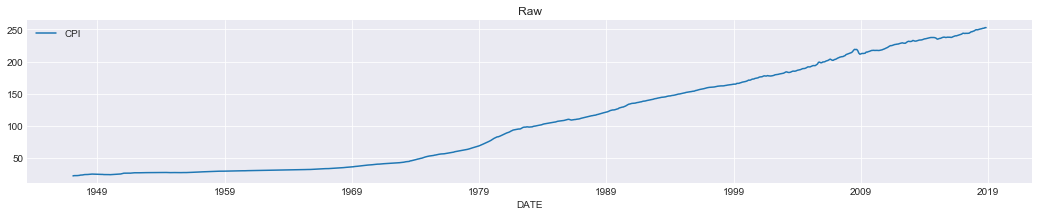

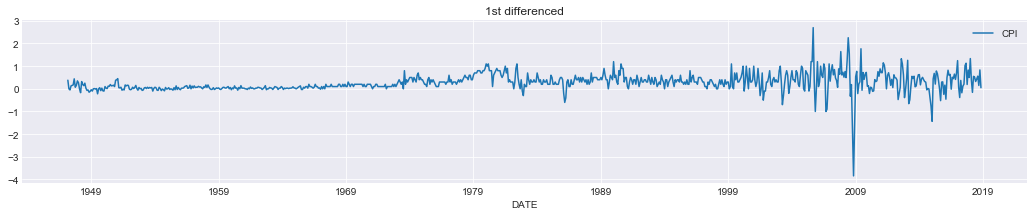

In [7]:
df.plot(figsize=(18, 3), grid=True)
plt.title("Raw")
plt.show()
d1.plot(figsize=(18, 3), grid=True)
plt.title("1st differenced")
plt.show()

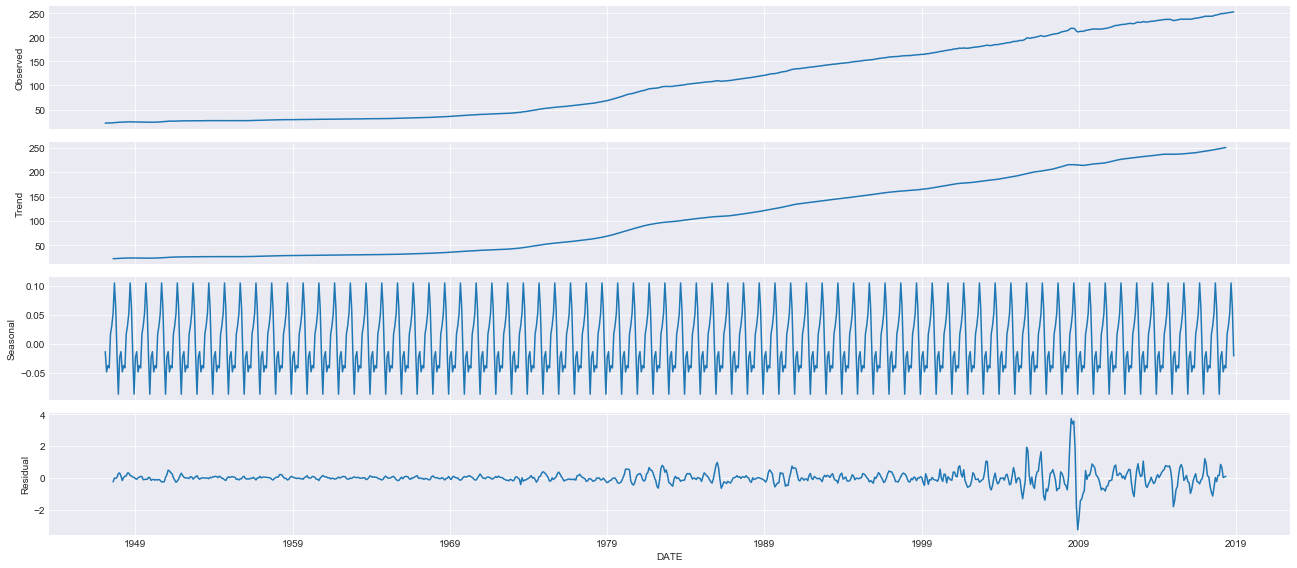

In [8]:
from pylab import rcParams
rcParams["figure.figsize"] = (18, 8)
rcParams["axes.grid"] = True
decomposition = sm.tsa.seasonal_decompose(df, model="additive")
fig = decomposition.plot()
plt.show()

In [28]:
# Grid Searching for Parameters
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [
    (x[0], x[1], x[2], 12)
    for x in list(itertools.product(p, d, q))
]

candidates = list()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(
            df,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False,
            freq="MS"
        )
        results = model.fit()
        candidates.append({
            "pdq": param,
            "seasonal_pdq": param_seasonal,
            "aic":results.aic
        })
        print(f"ARIMA{param}x{param_seasonal} - AIC:{results.aic}")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:10856.72760859943
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:9616.875114131946
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:4806.899759889123
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4249.371048565861
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:3897.5317784312224
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:3701.517743564931
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:3707.371999640399
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:3534.132420648775
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:9663.609913783976
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:8440.981627958288
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:3661.2441519439108
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:3190.031493143658
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2805.9994911418917
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2663.6651057006766
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2735.112734481929
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:2511.523768178102
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1152.849221855989
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1062.9130057169496
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1323.7

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1069.79435110989


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:781.4354279497329
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:775.7353308514128
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:756.6625484927832
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1161.4020070943907
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:571.7564085752792
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:749.5759233191336
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:579.0891651549141
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:882.0042878685655
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:564.1898149287871
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:788.0308424895685


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:786.0357593214524
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:1324.564204306875


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:1326.4971021079039
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:785.9783668340045
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:788.0260508424661
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:1071.3077690388359
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:779.8210488879728
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:554.6812057978219


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:562.3820694503833
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:1159.7010122060517


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:1165.818363532201
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:556.3977798501602
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:557.8995946890706
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:882.6997384326446


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:563.1317325412032
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:628.9852899245697
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:627.7520120075899


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:1178.2790902315962
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:565.6453793011381
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:627.6170416843969
ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:573.3023913586684
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:906.8639130807471
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:555.6756273522221
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:630.2251496177593
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:626.4824598991229
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:1158.1676684380893
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:555.2898511577772
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:627.9101371381491
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:561.542112363852
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:879.5482185593336
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:545.1975163492359


In [29]:
# # Grid Searching for Parameters
# p = q = range(10)
# d = [1]
# pdq_set = tuple(itertools.product(p, d, q))
# candidates = list()

# for (i, param) in enumerate(pdq_set):
#     progbar(i+1, len(pdq_set), max(len(pdq_set), 30))
#     try:
#         model = sm.tsa.statespace.SARIMAX(
#             df,
#             order=param,
#             enforce_stationarity=False,
#             enforce_invertibility=False,
#             freq="MS"
#         )
#         results = model.fit()
#         candidates.append({
#             "pdq": param,
#             "aic": results.aic
#         })
# #         print(f"ARIMA{param} - AIC:{results.aic}")
#     except:
#         continue

In [30]:
candidates.sort(key=lambda x:x["aic"])
from pprint import pprint
pprint(candidates[:5])
best_param = candidates[0]["pdq"]

[{'aic': 545.1975163492359, 'pdq': (1, 1, 1), 'seasonal_pdq': (1, 1, 1, 12)},
 {'aic': 554.6812057978219, 'pdq': (1, 0, 1), 'seasonal_pdq': (0, 0, 0, 12)},
 {'aic': 555.2898511577772, 'pdq': (1, 1, 1), 'seasonal_pdq': (0, 1, 1, 12)},
 {'aic': 555.6756273522221, 'pdq': (1, 1, 0), 'seasonal_pdq': (1, 1, 1, 12)},
 {'aic': 556.3977798501602, 'pdq': (1, 0, 1), 'seasonal_pdq': (1, 0, 0, 12)}]


In [38]:
# Fitting Seasonal ARIMA
model = sm.tsa.statespace.SARIMAX(
    df,
    order=best_param,
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq="MS"
)

results = model.fit()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [39]:
# print(results.summary())

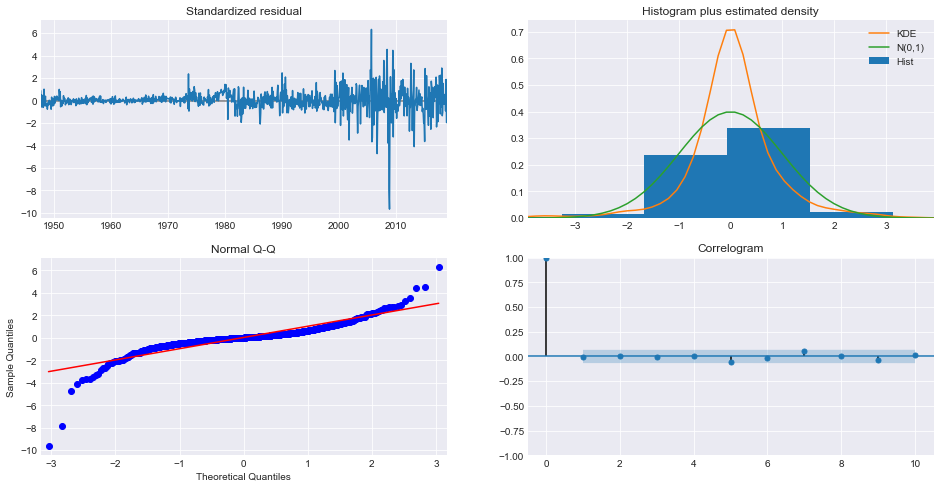

In [40]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [41]:
pred = results.get_prediction(start=pd.to_datetime("2000-01-01"), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.columns

Index(['lower CPI', 'upper CPI'], dtype='object')

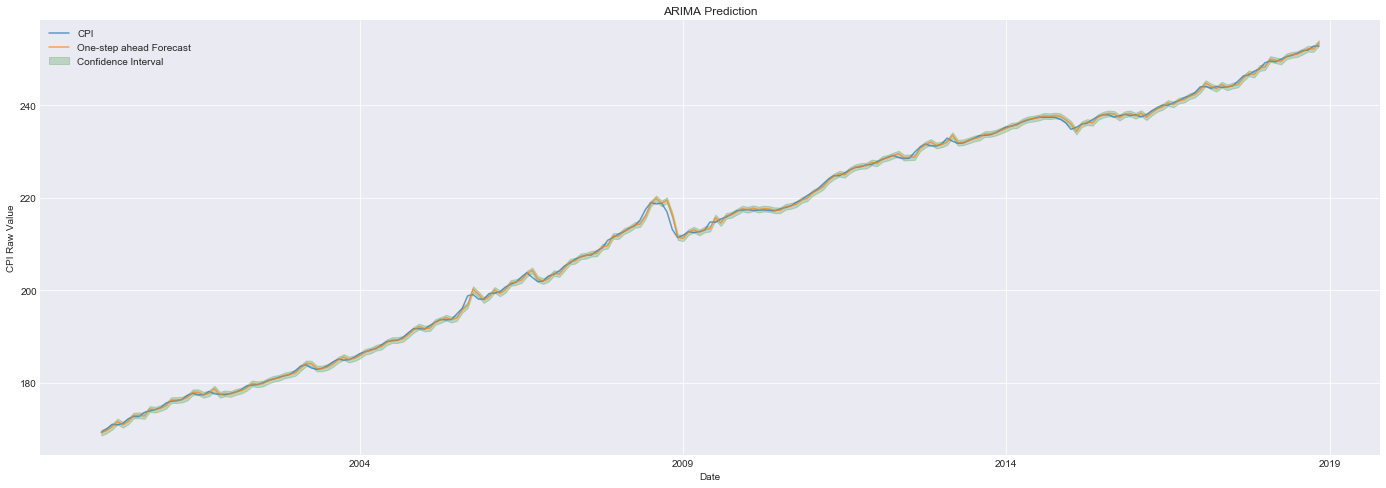

In [42]:
rcParams["figure.figsize"] = (24, 8)
ax = df[pd.to_datetime("2000-01-01"):].plot(label="observed", alpha=.7)
pred.predicted_mean.plot(ax=ax, label="One-step ahead Forecast", alpha=.7)
ax.fill_between(
    pred_ci.index,
    pred_ci["lower CPI"],
    pred_ci["upper CPI"],
    color="green",
    alpha=.2,
    label="Confidence Interval"
)
ax.set_xlabel("Date")
ax.set_ylabel("CPI Raw Value")
plt.title("ARIMA Prediction")
plt.legend()
plt.show()

In [43]:
predicted = pred.predicted_mean.values
observed = np.squeeze(df["2000-01-01":].values)
rmse = np.sqrt(np.mean(
    (predicted - observed) ** 2
))
print(rmse)

0.5550755090528378


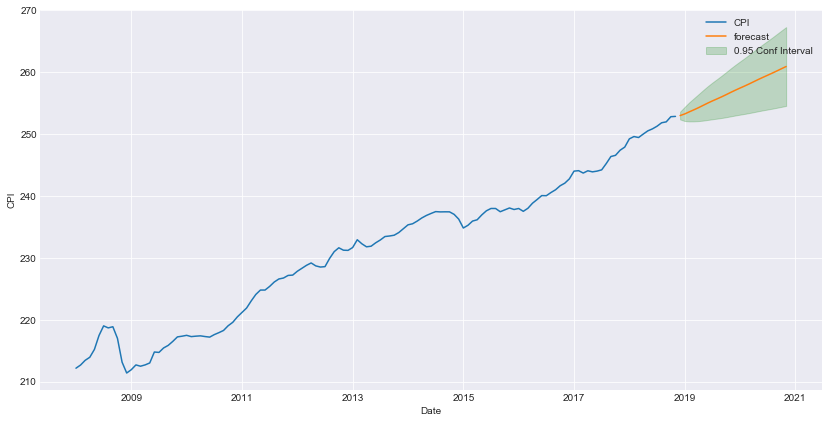

In [44]:
# Forecasting
alpha = 0.05
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int(alpha=alpha)

ax = df["2008-01-01":].plot(
    label="observed", figsize=(14, 7)
)
pred_uc.predicted_mean.plot(ax=ax, label="forecast")
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],  # Lower CI
    pred_ci.iloc[:, 1],  # Upper CI
    color="green",
    alpha=0.2,
    label=f"{1-alpha} Conf Interval"
)
ax.set_xlabel("Date")
ax.set_ylabel("CPI")

plt.legend()
plt.show()